In [68]:
import sys
import importlib

sys.path.insert(0, '/Users/awgol/code/syne-tune/')

import syne_tune
importlib.reload(syne_tune)

import syne_tune.experiments
importlib.reload(syne_tune.experiments)

from syne_tune.util import experiment_path, s3_experiment_path
importlib.reload(syne_tune.util)

import adam_scripts.utils
importlib.reload(adam_scripts.utils)

import pygmo

import numpy as np
import pandas as pd
import tqdm
import boto3

from syne_tune.backend.sagemaker_backend.instance_info import InstanceInfos
instance_info = InstanceInfos()

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import QuantileTransformer

In [69]:
boto3_client_sagemaker = boto3.client('sagemaker')
boto3_resource_cloudwatch = boto3.resource('cloudwatch')

In [70]:
SPEED_SYNE_TUNE_JOB_NAMES = (
    'speed-bs-it-nw-new-2022-02-21-18-05-01-921',
)

BLACKBOX_SPEED_S3_PATH = (
    's3://mnemosyne-team-bucket/dataset/'
    'hf-distilbert-on-imdb-static-blackbox/hf-distilbert-on-imdb-static-blackbox-speed.csv.zip')

In [73]:
df = pd.read_csv(BLACKBOX_SPEED_S3_PATH)

In [74]:
# Syne Tune's st_worker_time and st_tuner_cost do not account for either:
# a) the EC2 instance startup overhead time (customers don't pay for this)
# b) the time at the beginning of the running of the script (starting the script, setting up the dataloader etc)
# We assume an idealized scenario where we have each instance type already running and with dataloader prepared,
# such that they're all ready to start our jobs. Hence we can omit both effects a) and b).
# However, we still assume the attempts that fail due to OOM, incur the cost equivalent to SCRIPT_SETUP_OVERHEAD_TIME.
INSTANCE_STARTUP_OVERHEAD_TIME = 0  # in seconds
# This was estimated as the median of "BillableTimeInSeconds-st_worker_time" for runs of a given training script
# (gluonts-on-electricity or hugging-distil-bert-finetunes-on-imdb).
# For gluonts on 'deepar-speed-bs-32-2022-04-21-14-48-44-131': SCRIPT_SETUP_OVERHEAD_TIME = 65
# For distill-bert-on-imdb on 'loss-lr-wd-bs-2-2022-02-07-23-13-30-781': SCRIPT_SETUP_OVERHEAD_TIME = 410
SCRIPT_SETUP_OVERHEAD_TIME = 0  # in seconds

# The speed benchmarking experiments were run for max_run=5min timeout setting of the HuggingFace estimator.
# If we are more efficient about software engineering of the solution we could run only a few batches
# and do it cheaper.
ST_WORKER_TIME_DISCOUNT = 0.1

In [75]:
# Drop duplicates resulting from what I understand is the following issue
# https://github.com/awslabs/syne-tune/issues/214
temp = df.groupby(['trial_id', 'step']).loss.count().reset_index()
trial_ids_to_be_deleted = temp[temp.loss>1].trial_id.unique() 
trial_ids_to_be_deleted

array([2])

In [76]:
df.drop(df.index[df['trial_id'].isin(trial_ids_to_be_deleted)], inplace=True)

In [77]:
# speed-bs-it-nw-new-2022-02-21-18-05-01-921-82

In [78]:
# Compute time per samples
dfg = df.groupby(['trial_id'])

number_of_samples_processed = (
  dfg.step.max() * 
  dfg.config_per_device_train_batch_size.max() * 
  dfg.config_st_instance_type.max().map(lambda x: instance_info(x).num_gpu))

samples_processed_per_second = number_of_samples_processed / dfg.st_worker_time.max()
time_per_sample = dfg.st_worker_time.max() / number_of_samples_processed
cost_per_sample = time_per_sample * dfg.config_st_instance_type.max().map(lambda x: instance_info(x).cost_per_hour)

In [79]:
# The records that have only 100 steps record, which means that their time_per_sample cannot be estimated 
# by taking the difference between the first and last record.
# We do it this way such that the results are free of the bias reflected in st_tuner_time due to the 
# script_startup_overhead.

# These are trial_ids corresponding to the trials with only 100 steps records
dfg.step.max().index[np.argwhere((dfg.step.max()==100).to_numpy()).reshape(-1)]

Int64Index([82, 295, 377], dtype='int64', name='trial_id')

In [80]:
b = pd.concat([
    samples_processed_per_second, 
    time_per_sample,
    cost_per_sample,
    dfg.config_seed.max(),
    dfg.st_worker_cost.max(), 
    dfg.config_st_instance_type.max(), 
    dfg.config_per_device_train_batch_size.max(),
    dfg.config_dataloader_num_workers.max(),
], axis=1)
columns = ['samples_processed_per_second', 'time_per_sample', 'cost_per_sample']
b.columns = columns + list(b.columns)[len(columns):]

b = (
    b.groupby([
        'config_st_instance_type', 
        'config_per_device_train_batch_size', 
        'config_dataloader_num_workers'
    ]).agg({
        'samples_processed_per_second': 'mean',
        'time_per_sample': 'mean',
        'cost_per_sample': 'mean',
        'st_worker_cost': 'mean',
}).reset_index())

Add failed runs

In [81]:
# per_device_train_batch_size_list = [4, 8, 16, 24, 32, 40, 48]
per_device_train_batch_size_list = [8, 16, 24, 32, 40, 48]
dataloader_num_workers_list = [0, 1]
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]

In [82]:
names = [
    "config_st_instance_type", 
    "config_per_device_train_batch_size", 
    "config_dataloader_num_workers"
]

mind = pd.MultiIndex.from_product(
    [instance_types, per_device_train_batch_size_list, dataloader_num_workers_list], 
    names=names)
c = b.set_index(names).reindex(mind)

In [83]:
len(c)

168

In [84]:
len(instance_types)

14

In [85]:
2*14*6

168

In [86]:
for idx in c.st_worker_cost.isna().loc[lambda x: x==True].index:
    c.loc[idx].samples_processed_per_second = 0.0
    c.loc[idx].time_per_sample = 1.
    c.loc[idx].cost_per_sample = 1.
    c.loc[idx].config_seed = 1
    c.loc[idx].st_worker_cost = (instance_info(idx[0]).cost_per_hour /
                                 60. / 60. * SCRIPT_SETUP_OVERHEAD_TIME)

In [87]:
c = c.reset_index()

### Normalization

In [88]:
temp = c
y_all_points = np.stack([
    temp.time_per_sample,
    temp.cost_per_sample
], axis=-1)

In [89]:
y_all_points.shape

(168, 2)

In [97]:
normalizer = QuantileTransformer(output_distribution='uniform', n_quantiles=len(y_all_points))
normalizer.fit(y_all_points)

QuantileTransformer(n_quantiles=168)

In [98]:
ref_point = (1.+1e-15, 1.+1e-15)

In [99]:
def compute_hv(inputs_unnorm):
    inputs_unnorm_vec = np.stack([inputs_unnorm.time_per_sample, inputs_unnorm.cost_per_sample], axis=-1)
    inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
    hv = pygmo.hypervolume(inputs_norm_vec.tolist()).compute(ref_point)
    return hv

In [102]:
true_hv = compute_hv(c)
true_hv

0.9621356090214795

In [103]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

### Pareto optimal points

In [104]:
inputs_unnorm = c
inputs_unnorm_vec = np.stack([inputs_unnorm.time_per_sample, inputs_unnorm.cost_per_sample], axis=-1)
inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
pygmo.hypervolume(inputs_norm_vec.tolist()).get_points()

inputs_unnorm[is_pareto_efficient(inputs_norm_vec)]

,config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,samples_processed_per_second,time_per_sample,cost_per_sample,st_worker_cost
105,ml.g5.xlarge,40,1,74.675062,0.013391,0.013472,0.134718
155,ml.g5.12xlarge,48,1,236.335510,0.004231,0.024000,0.383999


### Reused code

In [105]:
data = dict()
costs = dict()

In [106]:
def compute_hvs_and_cost(temp, scenario_label, K):
    hvs_total = []
    costs_total = []
    for n in tqdm.trange(N):
        idxs = np.random.choice(K, size=K, replace=False)
        hvs_temp = []
        costs_temp = []
        for k in range(1, K + 1):
            temp2 = temp.iloc[idxs[:k]]
            hv = compute_hv(temp2)
            hvs_temp.append(hv)
            costs_temp.append(
                temp.st_worker_cost.iloc[idxs[k-1]] * ST_WORKER_TIME_DISCOUNT +
                SCRIPT_SETUP_OVERHEAD_TIME / 60. / 60. *
                instance_info(temp.config_st_instance_type.iloc[idxs[k-1]]).cost_per_hour
            )
        hvs_total.append(hvs_temp)
        costs_total.append(costs_temp)

    data[scenario_label] = np.array(hvs_total)
    costs[scenario_label] = np.array(costs_total).cumsum(axis=1)

## random

In [107]:
N = 100

In [108]:
temp = c
scenario_label = 'random'
K = len(temp)

compute_hvs_and_cost(temp, scenario_label, K)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.68it/s]


## only cheapest instance per GPU-type-and-number

In [109]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
#         'ml.g5.24xlarge',
    ]

temp = c.query('config_st_instance_type in @instance_types')
scenario_label = 'cheapest_instances'

K = len(temp)


compute_hvs_and_cost(temp, scenario_label, K)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.46it/s]


## deterministically determining largest possible batch_size using only 1 instance_type

In [110]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        'ml.g4dn.2xlarge',
        'ml.g4dn.4xlarge',
        'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        'ml.g5.2xlarge',
        'ml.g5.4xlarge',
        'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type'

K = len(temp)

compute_hvs_and_cost(temp, scenario_label, K)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += (
    2 * ST_WORKER_TIME_DISCOUNT * 
    temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.15it/s]


In [111]:
instance_types = [
        'ml.p3.2xlarge',
        'ml.p2.xlarge',
        'ml.p2.8xlarge',
        'ml.g4dn.xlarge',
        # 'ml.g4dn.2xlarge',
        # 'ml.g4dn.4xlarge',
        # 'ml.g4dn.8xlarge',
        'ml.g4dn.12xlarge',
        'ml.g5.xlarge',
        # 'ml.g5.2xlarge',
        # 'ml.g5.4xlarge',
        # 'ml.g5.8xlarge',
        'ml.g5.12xlarge',
        # 'ml.g5.24xlarge',
    ]


temp = c.query('config_st_instance_type in @instance_types')
temp = (
    temp
    .groupby('config_st_instance_type')
    .apply(lambda group: group.loc[group['config_per_device_train_batch_size'] == group['config_per_device_train_batch_size'].max()])
    .reset_index(drop=True)
)
scenario_label = 'determine_batch_size_one_instance_type_cheapest_instances'

K = len(temp)


compute_hvs_and_cost(temp, scenario_label, K)

# add the cost of running two runs for each instance_type
instance_type = 'ml.g5.xlarge'
costs[scenario_label] += 2 * temp.groupby('config_st_instance_type').st_worker_cost.min()[instance_type]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.55it/s]


## Reuseable code for loading Syne Tune Blackbox runs 

In [176]:
s3_bucket = 'mnemosyne-team-bucket'
syne_tune_folder = 'AdamG/syne-tune'

In [178]:
def populate_with_syne_tune_results(scenario_label, runs):
    temp_data = []
    temp_cost = []
    for run in runs:
        dfff = syne_tune.experiments.load_experiment(
            tuner_name=run,
            s3_bucket=s3_bucket, syne_tune_folder=syne_tune_folder,
        ).results

        inputs_unnorm_vec = np.stack([dfff['training-runtime-per-sample'], dfff['training-cost-per-sample']], axis=-1)
        inputs_norm_vec = normalizer.transform(inputs_unnorm_vec)
        temp_data.append([
            pygmo.hypervolume(inputs_norm_vec[:i+1].tolist()).compute(ref_point) 
            for i in range(len(dfff))
        ])

        temp_cost.append(np.cumsum(dfff.st_worker_cost))

    min_index = min(len(v) for v in temp_data)
    data[scenario_label] = np.zeros((len(temp_data), min_index))
    costs[scenario_label] = np.zeros((len(temp_data), min_index))
    for i in range(len(temp_data)):
        data[scenario_label][i, :] = temp_data[i][:min_index]
        costs[scenario_label][i, :] = temp_cost[i][:min_index]

In [183]:
def get_tuner_names_and_features(experiment_names):
    tuner_names_and_features = []
    for experiment_job_name in experiment_names:
        job_details = sagemaker_boto3.describe_training_job(TrainingJobName=experiment_job_name)
        features = job_details['HyperParameters']['features'].replace('"', '').split(' ')
        experiment_job_name_without_hash = '-'.join(experiment_job_name.split('-')[:-1])

        tuners_names = set()
        for my_bucket_object in my_bucket.objects.filter(Prefix=f'syne-tune/{experiment_job_name_without_hash}'):
            tuners_names.add(my_bucket_object.key.split('/')[2])

        tuner_names_and_features.append((features, tuners_names))
    return tuner_names_and_features

In [184]:
import math


def iqm(data, quantiles):
    """ interquantile mean along axis=0 """
    axis = 0
    k0 = math.floor(quantiles[0] * data.shape[axis])
    k1 = math.ceil(quantiles[1] * data.shape[axis])
    assert k1 > k0
    data = np.partition(data, k0, axis=axis)
    data[k0+1:] = np.partition(data[k0+1:], k1-k0-1, axis=axis)
    return np.mean(data[k0:k1+1], axis=axis)

## Load automated sweeps from S3 with deterministic_transform=0

In [133]:
import boto3
import sagemaker

In [134]:
sagemaker_boto3 = boto3.client('sagemaker')
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sagemaker.Session().default_bucket())

In [135]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = ['accurate-tamarin-Y3os', 'quantum-earwig-kY2f', 'classic-manatee-2Aam', 
     'remarkable-petrel-zdX4', 'groovy-woodlouse-xn4H', 'evasive-otter-vWyT', 
     'flawless-sponge-hTUL', 'idealistic-leopard-axOh', 'lavender-termite-DIR8', 
     'crystal-mole-p2Tt']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['discreet-bird-4a4z', 'incredible-perch-zED3', 'cerulean-dinosaur-XsdV', 
                        'phenomenal-booby-x9al', 'invaluable-scallop-BCZb', 'blazing-okapi-1JHE', 
                        'humongous-lizard-Qgon', 'spirited-malkoha-SKgz', 'hungry-lemming-o7MP', 
                        'imaginary-kudu-caEr']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['tireless-sidewinder-wqkF', 'overjoyed-spoonbill-4WIO', 'dexterous-cow-IoJp', 
                        'robust-jacamar-Il1a', 'dexterous-chachalaca-S36c', 'amorphous-hamster-D3ST', 
                        'observant-beluga-BRPe', 'tricky-quail-P3ef', 'rational-porcupine-p2sW', 
                        'unyielding-kakapo-JmBr']
else:
    raise Exception()
    
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]

In [136]:
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

In [137]:
tuner_names_and_features = get_tuner_names_and_features(experiment_names)
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = ','.join(f.replace('config_', '') for f in features)
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


## sweeps with deterministic_transform=1

In [138]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = ['steady-robin-EWOG', 'encouraging-stoat-gP0a', 'observant-guppy-R5da', 
                        'tunneling-toucanet-eH7R', 'qualified-crocodile-mrbl', 'daring-bloodhound-3qMk', 
                        'industrious-dolphin-5C6f', 'original-shark-3MYw', 'white-scorpion-w4KW', 
                        'agate-nautilus-a3pH']
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['tough-quail-LXeR', 'hasty-potoo-nOkm', 'heavenly-sparrow-sddJ', 
                        'outstanding-chihuahua-d0ro', 'secret-nightingale-sdMC', 'blue-alpaca-jVFO', 
                        'aquatic-butterfly-kQjp', 'positive-pony-kWoo', 'towering-rook-Hct5', 
                        'marigold-loon-mUD6', 
                        'nano-mushroom-hLZJ', 
                        'unique-moth-pqfs'
                       ]
else:
    raise Exception()

In [139]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

In [140]:
tuner_names_and_features = get_tuner_names_and_features(experiment_names)
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = 'det:'+','.join(f.replace('config_', '') for f in features)
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.52s/it]


## random ST

In [141]:
if INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 360 and ST_WORKER_TIME_DISCOUNT == 1.0:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 410 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = None
elif INSTANCE_STARTUP_OVERHEAD_TIME == 0 and SCRIPT_SETUP_OVERHEAD_TIME == 0 and ST_WORKER_TIME_DISCOUNT == 0.1:
    experiment_names = ['versed-mammoth-KgK9']
else:
    raise Exception()

In [142]:
experiment_names_without_hash = ['-'.join(x.split('-')[:-1]) for x in experiment_names]
# for i in experiment_names_without_hash:
#     !echo aws s3 cp ... s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ...
#     !aws s3 cp --recursive --quiet s3://sagemaker-us-west-2-640549960621/syne-tune/{i}/ ~/syne-tune/.

In [143]:
tuner_names_and_features = get_tuner_names_and_features(experiment_names)
for features, tuner_names in tqdm.tqdm(tuner_names_and_features):
    scenario_label = 'random-ST'
    runs = tuner_names

    populate_with_syne_tune_results(scenario_label, runs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


## Plotting settings

In [155]:
# Which quantiles to plot
k = 0.45
quantile_values_parameter = [0.5-k, 0.5+k]

In [156]:
# Colors
colormap_name = 'Set1'
cmap_colors = plt.get_cmap(colormap_name).colors

In [157]:
# List all combinations
list(data.keys())

['random',
 'cheapest_instances',
 'determine_batch_size_one_instance_type',
 'determine_batch_size_one_instance_type_cheapest_instances',
 'random-ST',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS',
 'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
 'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu',
 'instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers',
 'instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers',
 'instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers',
 'instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers',
 'det:st_instance_type,per_dev

In [158]:
# Subselect the traces to plot to avoid mess
traces_to_plot = [
    'random', 
#     'random-ST',
#     'cheapest_instances', 
#     'determine_batch_size_one_instance_type', 
# #     'determine_batch_size_one_instance_type_cheapest_instances', 
#     'det', 
    
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers', 
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
    'det:st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'det:st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'det:instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers', 
#     'det:instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers', 
#     'det:instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers', 
#     'det:instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers'
    
#     'det:instance_type_family,per_device_train_batch_size,dataloader_num_workers',
#     'det:instance_type_family,GPUMemory/batch_size,dataloader_num_workers',
#     'det:instance_type_family,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS',
#     'det:instance_type_family,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS'
#     'det:instance_type_family,num_gpu,per_device_train_batch_size,dataloader_num_workers',
    
    'st_instance_type,per_device_train_batch_size,dataloader_num_workers', 
#     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers', 
    'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
# #     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS', 
# #     'st_instance_type,per_device_train_batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
# #     'st_instance_type,GPUMemory/batch_size,dataloader_num_workers,GPUFP32TFLOPS*num_gpu', 
#     'instance_type_family,num_cpu,per_device_train_batch_size,dataloader_num_workers', 
# #     'instance_type_family,cost_per_hour,per_device_train_batch_size,dataloader_num_workers', 
# #     'instance_type_family,num_cpu,GPUMemory/batch_size,dataloader_num_workers', 
# #     'instance_type_family,cost_per_hour,GPUMemory/batch_size,dataloader_num_workers'
]

In [159]:
# If you want you can set custom plotting settings

# plotting_settings = {
#     'random': dict(color='b', label='random_search'),
# #     'random_b': dict(color='r', label='random_search_without_failed'),
# #     'cheapest_instances': dict(color='r', label='+ cheapest_instances'),
# #     'cheapest_instances_b': dict(color='m', label='+ cheapest_instances_without_failed'),
# #     'determine_batch_size': dict(color='g', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type': dict(color='c', label='+ determine_max_batch_size'),
# #     'determine_batch_size_one_instance_type_cheapest_instances': dict(color='g', label='+ subset_of_instances'),
# #     'mobo': dict(color='k', label='MOBO'),
#     'rf_mobo': dict(color='k', style='dashed', label='MOBO +GPUFP32TFLOPS'),
# #     'config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
# #     dict(color='k', style='dashed', label='config_st_instance_type,config_per_device_train_batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
#     'config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu': 
#     dict(color='k', style='dashed', label='config_st_instance_type,GPUMemory/batch_size,config_dataloader_num_workers,GPUFP32TFLOPS*num_gpu'),
# #     'rs_st': dict(color='m', label='RS-ST'),
# }


# Or you can use automated defaults

plotting_settings = {label: dict(color=cmap_colors[i%len(cmap_colors)], label=label)
                     for i, label in enumerate([i for i in data.keys() if i in traces_to_plot])
                     }

defaults = dict(color=None, style=None, label=None)
plotting_settings = {k: {kd: v[kd] if kd in v else vd 
                         for kd, vd in defaults.items()} 
                     for k, v in plotting_settings.items()}

## Plot: vs number of samples

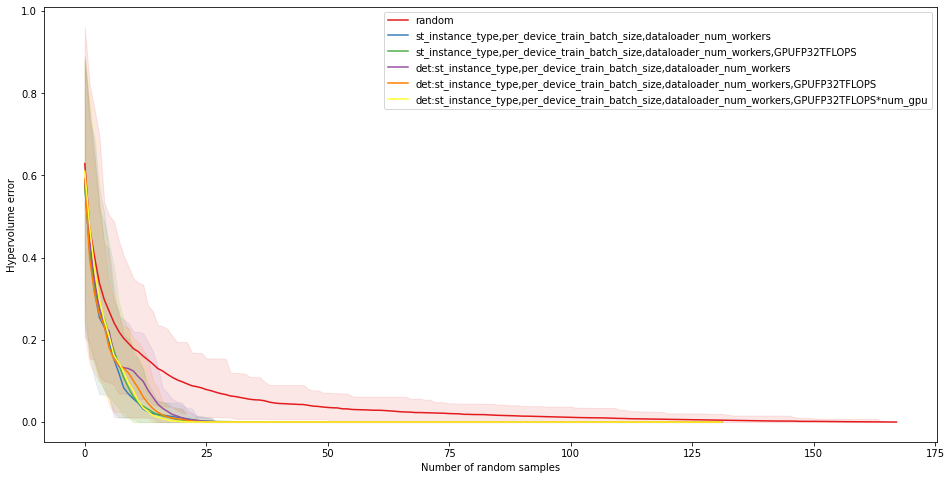

In [173]:
fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')

for k, v in plotting_settings.items():
    ax.plot(true_hv-np.mean(data[k], axis=0), color=v['color'], label=v['label'])

    quantiles = np.quantile(data[k], quantile_values_parameter, axis=0)
    ax.fill_between(x=np.arange(len(quantiles[0])), y1=true_hv-quantiles[0], y2=true_hv-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 100)
# ax.set_ylim(0, 10000)

ax.set_xlabel("Number of random samples")
ax.set_ylabel("Hypervolume error")

ax.legend()

## Plot: vs cost

The results of some methods (some traces on the plots, e.g., `cheapest_instances`, `determine_batch_size_one_instance_type`, `determine_batch_size_one_instance_type_cheapest_instances`) are not asymptotically exact because some of the Pareto-front instances are not included in the subset of configurations considered by those methods. 

In [167]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
    fig.add_trace(go.Scatter(x=interp_xs, y=true_hv-iqm(data_interpolated, quantiles=quantile_values_parameter),
                mode='lines',
                name=v['label']))

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
#     ax.fill_between(x=interp_xs, y1=quantiles[0], y2=quantiles[1], 
#                     alpha=0.1, color=v['color'])


fig.update_yaxes(type="log", range=(-4, 0))

fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
    xaxis_title="Cost in $",
    yaxis_title="Hypervolume error",
    legend=dict(
        yanchor="top",
        y=-0.1,
        xanchor="left",
        x=0.01
    )
)

fig.show()

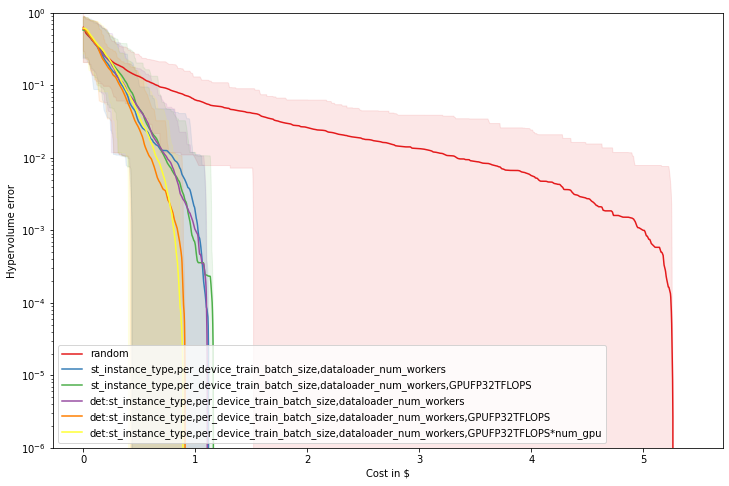

In [162]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
#     ax.plot(interp_xs, true_hv-np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])
    ax.plot(interp_xs, true_hv-iqm(data_interpolated, quantile_values_parameter), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=true_hv-quantiles[0], y2=true_hv-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
plt.yscale('log',base=10)
# ax.set_xlim(0., 40)
ax.set_ylim(1e-6, 1.)

ax.set_xlabel("Cost in $")
ax.set_ylabel("Hypervolume error")

ax.legend()

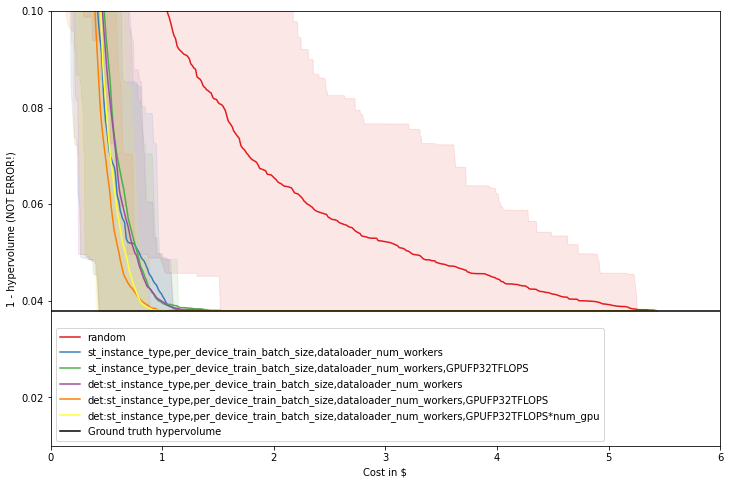

In [163]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

for k, v in plotting_settings.items():
    interp_xs_length = 2000
    data_interpolated = np.zeros((len(data[k]), interp_xs_length))
    interp_xs = np.linspace(0, costs[k].max(), interp_xs_length)
    for n in range(data[k].shape[0]):
        data_interpolated[n, :] = np.interp(interp_xs, xp=costs[k][n, :], fp=data[k][n, :])
    
    ax.plot(interp_xs, 1.-np.mean(data_interpolated, axis=0), color=v['color'], label=v['label'], linestyle=v['style'])

    quantiles = np.quantile(data_interpolated, quantile_values_parameter, axis=0)
    ax.fill_between(x=interp_xs, y1=1.-quantiles[0], y2=1.-quantiles[1], 
                    alpha=0.1, color=v['color'])

# ax.set_xlim(0, 40)

# plt.axvline(x=costs['determine_batch_size'].min(), color='b')
plt.axhline(y=1.-true_hv, color='k', label='Ground truth hypervolume')

# ax.set_xscale('log', base=10) 
# ax.set_xlim(0.5, max(c.max() for c in costs.values()))
# plt.yscale('log',base=10) 
ax.set_xlim(0., 6)
ax.set_ylim(1e-2, 0.1)

ax.set_xlabel("Cost in $")
ax.set_ylabel("1 - hypervolume (NOT ERROR!)")

ax.legend()